### Algorithm TD3
****
Initialize critic networks $Q_{\theta_1},Q_{\theta_2}$，and actor network $\pi_\phi$<br>
with random parameters $\theta_1, \theta_2,\phi$<br>
Initialize target networks $\theta'_1 \leftarrow \theta_1,\theta'_2 \leftarrow \theta_2, \phi' \leftarrow \phi$<br>
Initialize replay buffer $B$<br>
**for** t = 1 **to** $T$ **do**<br>
&nbsp;&nbsp;&nbsp;&nbsp;Select action with exploration noise $a \sim \pi_\phi(s) + \epsilon \;,\;\epsilon \sim N(0,\sigma)$ and observe reward $r$ and new state $s'$<br>
&nbsp;&nbsp;&nbsp;&nbsp;Store transition tuple ($s,a,r,s'$) in $B$<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;Sample mini-batch of $N$ transitions ($s,a,r,s'$) from $B$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\tilde{a}\leftarrow \pi_{\phi'}(s') + \epsilon,\quad \epsilon \sim clip(N(0,\tilde{\sigma}),-c,c)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y \leftarrow r + \gamma min_{i=1,2}Q_{\theta'_i}(s',\tilde{a})$<br>
&nbsp;&nbsp;&nbsp;&nbsp;Update critics $\theta_i \leftarrow argmin_{\theta_i}N^{-1}\sum(y-Q_{\theta_i}(s,a))^2$<br>
&nbsp;&nbsp;&nbsp;&nbsp;**if** t mod d **then**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Update $\phi$ by the deterministic policy gradient:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\nabla_\phi J(\phi)=N^{-1}\sum\nabla_aQ_{\theta_1}(s,a)|_{a=\pi_\phi (s)}\nabla_\phi\pi_\phi(s)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Update target networks:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\theta'_i \leftarrow \tau\theta_i + (1-\tau)\theta'_i \quad i=1,2$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\phi' \leftarrow \tau\phi +(1-\tau)\phi'$<br>
&nbsp;&nbsp;&nbsp;&nbsp;**end if**<br>
**end if**

### 与DDPG相比的三个tricks
1. 使用了两个Q-learning网络，选择target_Q较小的Q值，再使用两者和Q现实得出两个TD_error的和，用其更新Q现实网络
2. 延迟更新Policy网络,Value网络的更新速度是Policy的两倍(论文中推荐的超参)。并且在更新Policy网络时再更新三个target网络
3. 在target_policy选择动作时对每个动作增加不同高斯噪声并且clip，以此来降低Q function的error

$P(x) = \dfrac{1}{\text{to} - \text{from}}$

困扰许久的问题终于解决了。就是这两句代码的区别(在gpu或者cpu中构造高斯分布进行采样)，事实表明，只有在cpu中采样才可以收敛:
torch.FloatTensor(action).data.normal_(0, policy_noise).clamp(-noise_clip, noise_clip).to(device)<br>
torch.FloatTensor(action).to(device).data.normal_(0, policy_noise).clamp(-noise_clip, noise_clip)

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchviz
from IPython.display import clear_output
import pdb
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, state_column, action_column):
        self.current_state = np.zeros((buffer_size, state_column), dtype=np.float32)
        self.action = np.zeros((buffer_size, action_column), dtype=np.float32)
        self.next_state = np.zeros((buffer_size, state_column), dtype=np.float32)
        self.reward = np.zeros(buffer_size, dtype=np.float32)
        self.done = np.zeros(buffer_size, dtype=np.float32)
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.size, self.current_index = 0, 0
    
    def store(self, current_state, action, next_state, reward, done):
        self.current_state[self.current_index] = current_state
        self.action[self.current_index] = action
        self.next_state[self.current_index] = next_state
        self.reward[self.current_index] = reward
        self.done[self.current_index] = done
        self.size = min((self.size + 1), buffer_size)
        self.current_index = (self.current_index + 1) % self.buffer_size
    
    def sample(self):
        idx = np.random.choice(self.size, self.batch_size)
        return dict(current_state = torch.FloatTensor(self.current_state[idx]).to(device),
                    action = torch.FloatTensor(self.action[idx]).to(device),
                    next_state = torch.FloatTensor(self.next_state[idx]).to(device),
                    reward = torch.FloatTensor(self.reward[idx]).unsqueeze(1).to(device),
                    done = torch.FloatTensor(self.done[idx]).unsqueeze(1).to(device))
    
    def __len__(self):
        return self.size

In [3]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, init_w=3e-2):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(state_dim + action_dim, 400)
        self.linear2 = nn.Linear(400, 300)
        self.linear3 = nn.Linear(300, 1)
    
    def forward(self, state, action):
        data_cat = torch.cat((state, action), dim=1)
        value = F.relu(self.linear1(data_cat))
        value = F.relu(self.linear2(value))
        value = self.linear3(value)
        return value

class Actor(nn.Module):
    def __init__(self, in_dim, out_dim, max_action, init_w=3e-2):
        super(Actor, self).__init__()
        
        self.max_action = max_action

        self.linear1 = nn.Linear(in_dim, 400)
        self.linear2 = nn.Linear(400, 300)
        self.linear3 = nn.Linear(300, out_dim)
    
    def forward(self, state):
        action = F.relu(self.linear1(state))
        action = F.relu(self.linear2(action))
        action = torch.tanh(self.linear3(action)) * self.max_action
        return action

In [4]:
def td3_train(step):
    for i in range(step):
        samples = replay_buffer.sample()
        state, action, next_state = samples["current_state"], samples["action"], samples["next_state"]
        reward, done = samples["reward"], samples["done"]
        
        action_ = action.cpu().numpy()
        noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).clamp(-noise_clip, noise_clip).to(device)
        next_action = (target_actor_network(next_state) + noise).clamp(-max_action, max_action)

        first_target_value = target_critic_network_1(next_state, next_action)
        second_target_value = target_critic_network_2(next_state, next_action)
        Q_target_next = torch.min(first_target_value, second_target_value)
        target_value = reward + (1.0-done) * gamma * Q_target_next
        first_Q_value = critic_network_1(state, action)
        second_Q_value = critic_network_2(state, action)
        
        critic_loss_1 = F.mse_loss(target_value.detach(), first_Q_value)
        critic_loss_2 = F.mse_loss(target_value.detach(), second_Q_value)

        critic_optimizer_1.zero_grad()
        critic_loss_1.backward()
        critic_optimizer_1.step()

        critic_optimizer_2.zero_grad()
        critic_loss_2.backward()
        critic_optimizer_2.step()
    
        if i % actor_update == 0:
            actor_loss = -critic_network_1(state, actor_network(state)).mean()

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            for target_param, param in zip(target_actor_network.parameters(), actor_network.parameters()):
                target_param.data.copy_(target_param.data*(1.0-soft_tau) + param.data * soft_tau)
            for target_param, param in zip(target_critic_network_1.parameters(), critic_network_1.parameters()):
                target_param.data.copy_(target_param.data*(1.0-soft_tau) + param.data * soft_tau)
            for target_param, param in zip(target_critic_network_2.parameters(), critic_network_2.parameters()):
                target_param.data.copy_(target_param.data*(1.0-soft_tau) + param.data * soft_tau)
            
    return (critic_loss_1 + critic_loss_2).item(), actor_loss.item()

In [5]:
def take_action(episode, state):
    # actor_network.eval()
    with torch.no_grad():
        action = actor_network(torch.FloatTensor(state.flatten()).to(device))
        action = action.detach().cpu().numpy()
    noise = np.random.normal(0, expl_noise, size=action_space)
    if episode > episodes / 2 :
        tmp = np.random.randint(2, size=action_space)
    else :
        tmp = np.ones(action_space)
    action = (action + noise * tmp).clip(-max_action, max_action)
    # actor_network.train()
    return action

In [6]:
def smooth_plot(factor, item, plot_decay):
    item_x = np.arange(len(item))
    item_smooth = [np.mean(item[i:i+factor]) if i > factor else np.mean(item[0:i+1])
                  for i in range(len(item))]
    for i in range(len(item)// plot_decay):
        item_x = item_x[::2]
        item_smooth = item_smooth[::2]
    return item_x, item_smooth
    
def plot(episode, rewards, critic_losses, actor_losses, episode_steps):
    clear_output(True)
    rewards_x, rewards_smooth = smooth_plot(10, rewards, 350)
    critic_losses_x, critic_losses_smooth = smooth_plot(10, critic_losses, 30000)
    actor_losses_x, actor_losses_smooth = smooth_plot(10, actor_losses, 30000)
    episode_steps_x, episode_steps_smooth = smooth_plot(10, episode_steps, 350)
    
    plt.figure(figsize=(18, 16))
    plt.subplot(411)
    plt.title('episode %s. Reward: %s'%(episode, rewards_smooth[-1]))
    plt.plot(rewards, label="Rewards", color='lightsteelblue', linewidth='1')
    plt.plot(rewards_x, rewards_smooth, label='Smothed_Rewards', color='darkorange', linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(412)
    plt.title('Critic_Losses') #%s. Losses: %s'%(episode, critic_losses_smooth[-1]))
    plt.plot(critic_losses,label="Critic_Losses",color='lightsteelblue',linewidth='1')
    plt.plot(critic_losses_x, critic_losses_smooth, 
             label="Smoothed_Critic_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(413)
    plt.title('Actor_Losses') #%s. Losses: %s'%(episode, actor_losses_smooth[-1]))
    plt.plot(actor_losses,label="Actor_Losses",color='lightsteelblue',linewidth='1')
    plt.plot(actor_losses_x, actor_losses_smooth, 
             label="Smoothed_Actor_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(414)
    plt.title('Episode_Steps %s. Steps: %s'%(episode, episode_steps_smooth[-1]))
    plt.plot(episode_steps,label="Episode_Steps",color='lightsteelblue',linewidth='1')
    plt.plot(episode_steps_x, episode_steps_smooth, 
             label="Episode_Steps_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.show()

In [7]:
## hyperparameters ##

# env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v0"
# env_name = "BipedalWalkerHardcore-v2"
env_name = "BipedalWalker-v2"
buffer_size = int(1e5)
batch_size = 100
episodes = 1000
steps = 3000
expl_noise = 0.2
learning_rate = 1e-3
gamma=0.99
policy_noise=0.3
noise_clip=0.5
soft_tau=0.001
actor_update = 2

## hyperparameters ##

env = gym.make(env_name)
env.seed(0)
max_action = env.action_space.high[0]

state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]

critic_network_1 = Critic(state_space, action_space).to(device)
target_critic_network_1 = Critic(state_space, action_space).to(device)
critic_network_2 = Critic(state_space, action_space).to(device)
target_critic_network_2 = Critic(state_space, action_space).to(device)
actor_network = Actor(state_space, action_space, max_action).to(device)
target_actor_network = Actor(state_space, action_space, max_action).to(device)

target_critic_network_1.load_state_dict(critic_network_1.state_dict())
target_critic_network_2.load_state_dict(critic_network_2.state_dict())
target_actor_network.load_state_dict(actor_network.state_dict())

critic_optimizer_1 = optim.Adam(critic_network_1.parameters(), lr=learning_rate)
critic_optimizer_2 = optim.Adam(critic_network_2.parameters(), lr=learning_rate)
actor_optimizer = optim.Adam(actor_network.parameters(), lr=learning_rate)

replay_buffer = ReplayBuffer(buffer_size, batch_size, state_space, action_space)

两个原因: td3_train(i+1)和-max_action.astype(float)

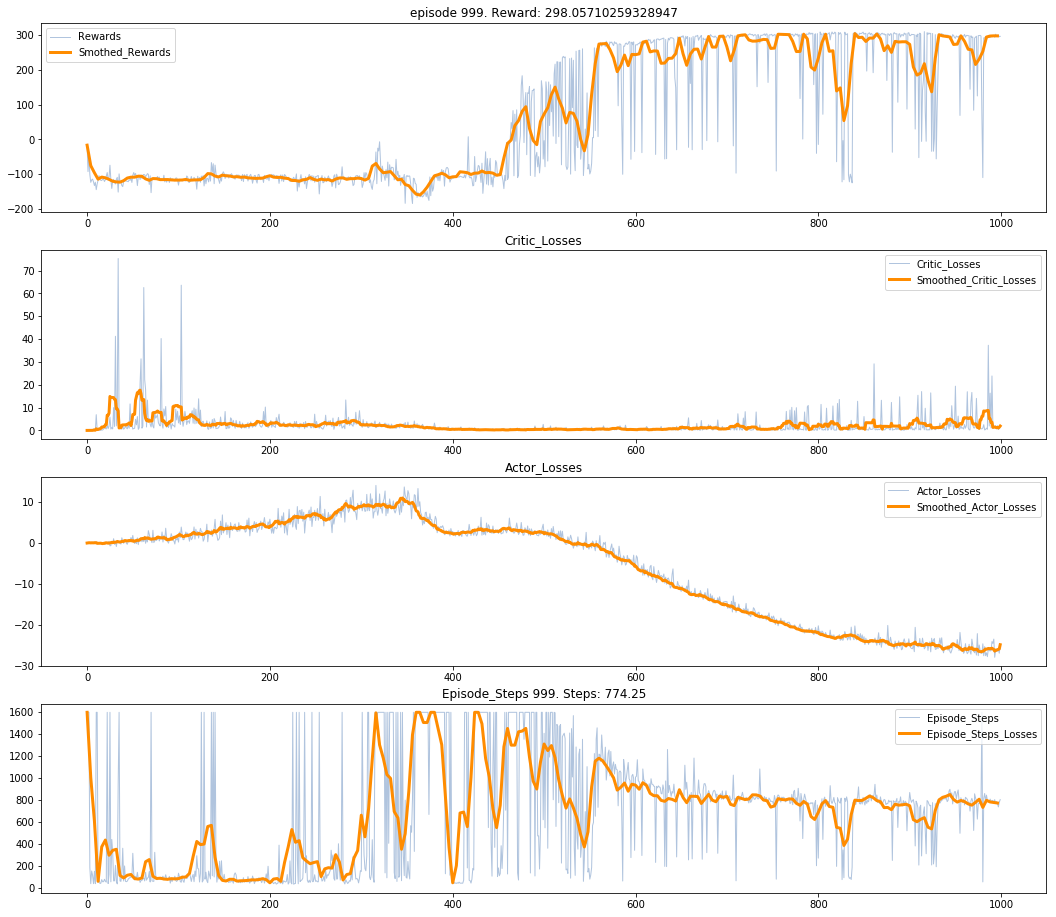

In [8]:
critic_losses, actor_losses, all_rewards, episode_steps = [], [], [], []
for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    for i in range(steps):
        action = take_action(episode, state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.store(state, action, next_state.flatten(), reward, done)      
        state = next_state
        episode_reward += reward
        if done or i==(steps-1):
            if len(replay_buffer) > batch_size:
                critic_loss, actor_loss = td3_train(i+1)
                critic_losses.append(critic_loss)
                actor_losses.append(actor_loss)
            episode_steps.append(i)
            break
    
    all_rewards.append(episode_reward)
    plot(episode, all_rewards, critic_losses, actor_losses, episode_steps)

In [9]:
#torch.save(actor_network.state_dict(), "./model/BipedalWalker-v2_TD3.pth")

In [10]:
# actor_network = Actor(state_space, action_space, max_action)
# actor_network.load_state_dict(torch.load("./model/BipedalWalker-v2_TD3.pth"))
# actor_network.eval()

from IPython import display
# env = gym.make(env_name)
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(1000):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    actor_network = actor_network.cpu()
    
    action = actor_network(torch.FloatTensor(state)).detach().numpy()
    # print(action)
    # action = env.action_space.sample()
    next_state, _, done, _ = env.step(action)
    if done: 
        state = env.reset()
    state = next_state

NoSuchDisplayException: Cannot connect to "None"